![Semillero Astrofisica](../logo.PNG)

---
# Ecuaciones Diferenciales Ordinarias: Introducción 


Carlos Andrés del Valle (cdelv@unal.edu.co)

---

Vamos a resolver la ecuación

\begin{equation}
    y^{\prime\prime}(t)-2y^\prime(t)+10y(t)=0
\end{equation}

Con las condiciones iniciales y de frontera
\begin{equation}
    y(t)=-2; \qquad y^\prime(t)=1
\end{equation}

La solución analítica es 
\begin{equation}
    y(t)=e^t\left(\sin{(3t)}-2\cos{(3t)}\right)
\end{equation}

In [1]:
import deepxde as dde
import numpy as np

#Usar doble precisión si la GPU lo soporta. Float32 por defecto.
dde.config.real.set_float64()

#para cambiar el backend
#dde.backend.set_default_backend('tensorflow')
#!export DDE_BACKEND=tensorflow

def func(t):
    return np.exp(t)*(np.sin(3*t)-2*np.cos(3*t))

Using backend: tensorflow.compat.v1

2022-10-22 10:20:44.691490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 10:20:44.810970: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-22 10:20:44.815124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-22 10:20:44.815137: I tensorflow/stream_executor/cuda/cudart_stub.cc:

Instructions for updating:
non-resource variables are not supported in the long term


2022-10-22 10:20:45.974078: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-22 10:20:45.974123: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


## 1. Definir la Ecuación a Resolver

In [2]:
# Ecuación diferencial a resolver
# t es el vector de coordenadas que entra a la red, en este caso el tiempo
# y es el output de la red neuronal 
def ode(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    d2y_dt2 = dde.grad.hessian(y, t)
    return d2y_dt2 - 2*dy_dt + 10*y

## 2. Definir Dominio de la Ecuación

Como tenemos solo dependencia temporal, podemos aprovechar el dominio TimeDomain

~~~python
class deepxde.geometry.timedomain.TimeDomain(t0, t1)
~~~

Esta clase de dominio crea el booleano para definir las coondiciones iniciales

~~~pyhton
on_initial(t)
~~~

In [3]:
geom = dde.geometry.TimeDomain(0, 3)

## 3. Definir Condiciones Iniciales y de Frontera

Como estamos resolviendo una ODE, entonces solo tenemos dos condiciones iniciales: $y(0)=-1$;  $y^\prime(0)=0$. Para la condición inicial en la variable:

~~~python
class deepxde.icbc.initial_conditions.IC(geom, 
                                         func, 
                                         on_initial, 
                                         component=0)
~~~

Initial conditions: y([x, t0]) = func([x, t0]). Para la condición sobre la derivada:

~~~python
class deepxde.icbc.boundary_conditions.OperatorBC(geom, 
                                                  func, 
                                                  on_boundary)
~~~

General operator boundary conditions: func(inputs, outputs, X) = 0. 

- **func:** A function takes arguments (inputs, outputs, X) and outputs a tensor of size N x 1, where N is the length of inputs. inputs and outputs are the network input and output tensors, respectively; X are the NumPy array of the inputs.

Ver detalles en https://deepxde.readthedocs.io/en/latest/modules/deepxde.icbc.html?highlight=boundary_conditions.OperatorBC#deepxde.icbc.boundary_conditions.OperatorBC

In [4]:
def in_bdr(X, on_initial):
    return on_initial and np.isclose(X[0], 0)

def IC_1(inputs):
    return -2

def IC_2(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs) - 1 #=0 #se define igual que la ecuación

Ic1 = dde.icbc.IC(        geom, IC_1, in_bdr)
Ic2 = dde.icbc.OperatorBC(geom, IC_2, in_bdr)

## 4. Crear Datos de Entrenamiento

vamos a crear los datos de entrenamiento

~~~python
class deepxde.data.pde.TimePDE(geometryxtime, 
                               pde, 
                               ic_bcs, 
                               num_domain=0, 
                               num_boundary=0, 
                               num_initial=0, 
                               train_distribution='Hammersley', 
                               anchors=None, 
                               exclusions=None, 
                               solution=None, 
                               num_test=None, 
                               auxiliary_var_function=None
~~~

Detalles en https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html?highlight=data.TimePDE#deepxde.data.pde.TimePDE. 

In [5]:
data = dde.data.TimePDE(geom, ode, [Ic1, Ic2], 62, 4, solution=func, num_test=100)

## 5. Crear la Red Neuronal

Vamos a utilizar una **Fully-connected neural network**. Existe la **Parallel fully-connected neural network** que usa una subred para cada salida. 

~~~python
class deepxde.nn.tensorflow.fnn.FNN(layer_sizes, activation, 
                                    kernel_initializer, 
                                    regularization=None, 
                                    dropout_rate=0)
~~~
Existen muchas funciones de activación, inicializadores y reguladores. Se pueden usar los que vienen hechos por defecto en el back-end que estamos utilizando, en este caso **TensorFlow**. Dejo donde revisar las diferentes opciones

- **Funciones de Activación:** https://www.tensorflow.org/api_docs/python/tf/keras/activations
- **Inicializadores:** https://www.tensorflow.org/api_docs/python/tf/keras/initializers
- **Reguladores:** https://www.tensorflow.org/api_docs/python/tf/keras/regularizers

In [6]:
layer_size = [1] + [30]*3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

## 6. Compilar y Entrenar el Modelo

DeepXDE tiene una función que se encarga de compilar el modelo con el optimizador, learnign rate, métricas y estrategias de entrenamiento que queramos. Nuevamente, hay muchas opciones disponibles. 

~~~python
class deepxde.model.Model.compile(optimizer, 
                                  lr=None, 
                                  loss='MSE', 
                                  metrics=None, 
                                  decay=None, 
                                  loss_weights=None, 
                                  external_trainable_variables=None)
~~~

~~~python
class deepxde.model.Model.train(iterations=None, 
                                batch_size=None, 
                                display_every=1000, 
                                disregard_previous_best=False, 
                                callbacks=None, 
                                model_restore_path=None, 
                                model_save_path=None, 
                                epochs=None)
~~~

La descripción de los parámetros la pueden encontrar en https://deepxde.readthedocs.io/en/latest/modules/deepxde.html?highlight=deepxde.model#module-deepxde.model. 

In [7]:
# Modelo
model = dde.Model(data, net)

# Optimizador Adam
model.compile("adam", lr=.001, loss_weights=[0.01, 1, 1], metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=7000)

Compiling model...
Building feed-forward neural network...
'build' took 0.033853 s



/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-10-22 10:20:47.315552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.265344 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.42e-01, 4.00e+00, 3.12e-01]    [1.47e-01, 4.00e+00, 3.12e-01]    [9.97e-01]    


2022-10-22 10:20:47.552418: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


1000      [4.27e-01, 5.48e-02, 2.17e-04]    [4.46e-01, 5.48e-02, 2.17e-04]    [1.00e+00]    
2000      [4.20e-01, 5.30e-02, 1.94e-04]    [4.42e-01, 5.30e-02, 1.94e-04]    [9.99e-01]    
3000      [4.03e-01, 4.88e-02, 7.46e-05]    [4.24e-01, 4.88e-02, 7.46e-05]    [9.77e-01]    
4000      [3.58e-01, 4.17e-02, 1.82e-03]    [3.78e-01, 4.17e-02, 1.82e-03]    [9.25e-01]    
5000      [3.20e-01, 3.86e-02, 2.02e-04]    [3.38e-01, 3.86e-02, 2.02e-04]    [8.85e-01]    
6000      [2.76e-01, 3.27e-02, 2.04e-04]    [2.94e-01, 3.27e-02, 2.04e-04]    [8.32e-01]    
7000      [2.26e-01, 2.63e-02, 2.94e-04]    [2.42e-01, 2.63e-02, 2.94e-04]    [7.60e-01]    

Best model at step 7000:
  train loss: 2.53e-01
  test loss: 2.69e-01
  test metric: [7.60e-01]

'train' took 5.310483 s



## 7. Visualizar la Solución

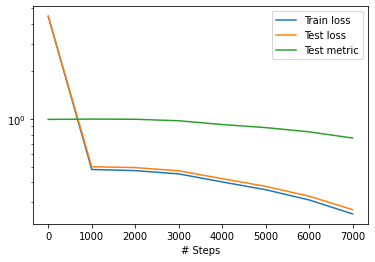

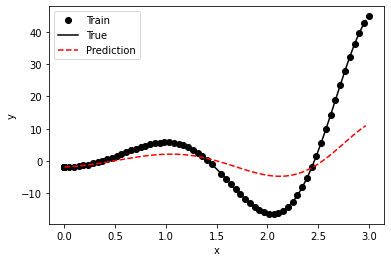

In [8]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True) 

## 8. Mejorar la predicción

Vamos a usar un optimizador de segundo orden que ayuda mucho a la convergencia de la solución. Para cambiar los parámetros del optimizador **LBFGS**

~~~
dde.optimizers.set_LBFGS_options
~~~

Estas opciones son

~~~python
deepxde.optimizers.config.set_LBFGS_options(maxcor=100, 
                                            ftol=0, 
                                            gtol=1e-08, 
                                            maxiter=15000, 
                                            maxfun=None, 
                                            maxls=50)
~~~

y se pueden encontrar en https://deepxde.readthedocs.io/en/latest/modules/deepxde.optimizers.html?highlight=optimizers.set_LBFGS_options#deepxde.optimizers.config.set_LBFGS_options

Este optimizador no permite que se hagan tests a medida que se entrena la red.

In [9]:
# Optimizador L-BFGS-B
dde.optimizers.config.set_LBFGS_options(maxiter=1000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.129911 s

Training model...

Step      Train loss                        Test loss                         Test metric
7000      [2.26e+01, 2.63e-02, 2.94e-04]    [2.42e+01, 2.63e-02, 2.94e-04]    []  
8000      [1.56e-01, 5.48e-01, 1.04e-04]                                          
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  Objective function value: 0.567375
  Number of iterations: 1000
  Number of functions evaluations: 1205
8205      [1.06e-01, 4.61e-01, 1.03e-04]    [2.94e+02, 4.61e-01, 1.03e-04]    []  

Best model at step 7000:
  train loss: 2.53e-01
  test loss: 2.69e-01
  test metric: [7.60e-01]

'train' took 3.628589 s



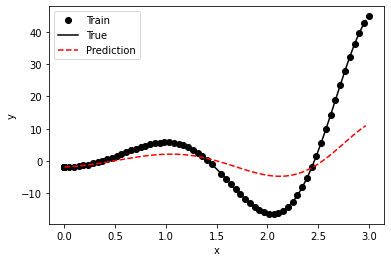

In [10]:
dde.utils.external.plot_best_state(train_state)

In [11]:
#dde.utils.external.plot_loss_history(losshistory) #hay un bug y esto no está funcionando